# The Joker Tutorial

In [66]:
import thejoker as tj
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

from thejoker import JokerPrior, TheJoker, RVData
from thejoker.plot import plot_rv_curves
from astropy.visualization.units import quantity_support

(-10, 200)

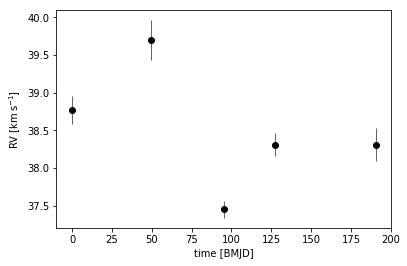

In [44]:
t = [0., 49.452, 95.393, 127.587, 190.408]
rv = [38.77, 39.70, 37.45, 38.31, 38.31] * u.km/u.s
err = [0.184, 0.261, 0.112, 0.155, 0.223] * u.km/u.s
data = tj.RVData(t=t, rv=rv, rv_err=err)
ax = data.plot() 
ax.set_xlim(-10, 200) 

We next need to specify the prior distributions for the parameters of The Joker. The default prior, explained in the docstring of default(), assumes some reasonable defaults where possible, but requires specifying the minimum and maximum period to sample over, along with parameters that specify the prior over the linear parameters in The Joker (the velocity semi-amplitude, K, and the systemic velocity, v0):

In [45]:
prior = tj.JokerPrior.default(P_min=2*u.day, P_max=256*u.day,
                              sigma_K0=30*u.km/u.s,
                              sigma_v=100*u.km/u.s)

With the data and prior created, we can now instantiate the sampler object and run the rejection sampler:


In [46]:
joker = tj.TheJoker(prior)

Of the 500_000 prior samples we generated, only some pass the rejection sampling step of The Joker. Let’s visualize the surviving samples in the subspace of the period 𝑃 and velocity semi-amplitude 𝐾. We’ll also plot the true values as a green marker. As a separate plot, we’ll also visualize orbits computed from these posterior samples (check the source code below to see how these were made):

(-5, 205)

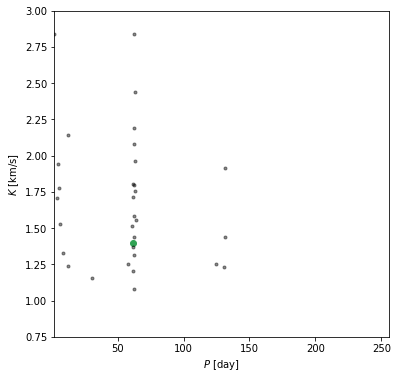

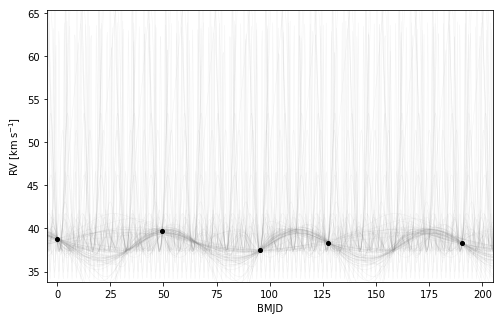

In [75]:
prior = JokerPrior.default(P_min=2*u.day, P_max=256*u.day,
                           sigma_K0=30*u.km/u.s, sigma_v=100*u.km/u.s)
joker = TheJoker(prior)

prior_samples = prior.sample(size=500_000)
joker_samples = joker.rejection_sample(data, prior_samples)

fig, ax = plt.subplots(1, 1, figsize=(6,6)) # doctest: +SKIP
ax.scatter(joker_samples['P'].value, joker_samples['K'].to(u.km/u.s).value,
           marker='.', color='k', alpha=0.45) # doctest: +SKIP
ax.set_xlabel("$P$ [day]")
ax.set_ylabel("$K$ [km/s]")
ax.set_xlim(2, 256)
ax.set_ylim(0.75, 3.)

ax.scatter(61.942, 1.3959, marker='o', color='#31a354', zorder=-100)

fig, ax = plt.subplots(1, 1, figsize=(8,5)) # doctest: +SKIP
t_grid = np.linspace(-10, 210, 1024)
plot_rv_curves(joker_samples, t_grid, rv_unit=u.km/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888'))
ax.set_xlim(-5, 205)

Text(0, 0.5, '$e$')

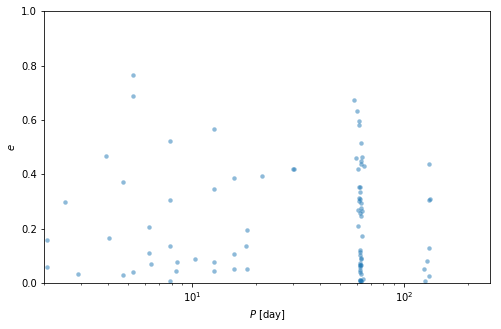

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

with quantity_support():
    ax.scatter(joker_samples['P'],
               joker_samples['e'],
               s=20, lw=0, alpha=0.5)

ax.set_xscale('log')
ax.set_xlim(prior.pars['P'].distribution.a,
            prior.pars['P'].distribution.b)
ax.set_ylim(0, 1)

ax.set_xlabel('$P$ [day]')
ax.set_ylabel('$e$')

# TwoBody Code -- Adapted from Bedell github: https://github.com/megbedell/astrometric-jupiters

In [48]:
from astropy.time import Time
import astropy.coordinates as coord
from twobody import KeplerOrbit, Barycenter, TwoBodyKeplerElements

In [49]:
origin = coord.ICRS(ra=14.745*u.deg, dec=71.512*u.deg,
                    distance=10.*u.pc,
                    pm_ra_cosdec=0.*u.mas/u.yr,
                    pm_dec=0.*u.mas/u.yr,
                    radial_velocity=0.*u.km/u.s)
barycen = Barycenter(origin=origin, t0=Time('J2014'))

In [50]:
mass_ratio = (1. * u.jupiterMass) / (1. * u.jupiterMass + 1. * u.solMass) # m2 / (m1 + m2)


In [51]:
elements = TwoBodyKeplerElements(a=5.20336301*u.au, e=0.04839266,
                  omega=20*u.deg, i=10*u.deg, Omega=0*u.deg,
                  M0=34.40438*u.deg, t0=Time('J2015.0'),
                  m1=1.*u.jupiterMass, m2=1.*u.solMass)
orb = KeplerOrbit(elements.secondary, barycenter=barycen)
#orb.K = mass_ratio * 2*np.pi * orb.a * np.sin(orb.i) / (orb.P * np.sqrt(1 - orb.e**2))

In [64]:
t = Time('J2010') + np.linspace(0, 2*orb.P.value, 10000)*orb.P.unit
print(t)

['J2010.000' 'J2010.002' 'J2010.005' ... 'J2033.723' 'J2033.725'
 'J2033.728']


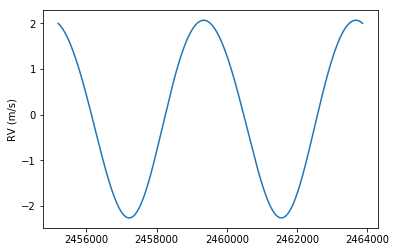

In [53]:
plt.plot(t.jd, orb.K.to(u.m/u.s) * orb.unscaled_radial_velocity(t))
plt.ylabel('RV (m/s)');

In [56]:
orb_ref = orb.reference_plane(t)

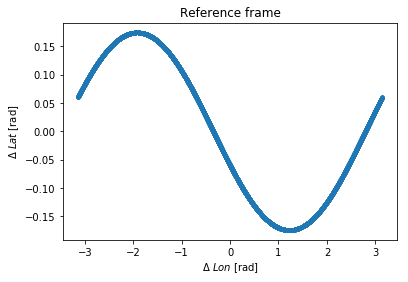

In [55]:
fig,ax = plt.subplots(1, 1) 
ax.plot(orb_ref.lon.wrap_at(180*u.deg).rad,
        orb_ref.lat.rad, marker='.', ls='') 
ax.set_ylabel(r'$\Delta\ Lat$ [{0:latex_inline}]'.format(u.rad)) 
ax.set_xlabel(r'$\Delta\ Lon$ [{0:latex_inline}]'.format(u.rad))
ax.set_title('Reference frame');

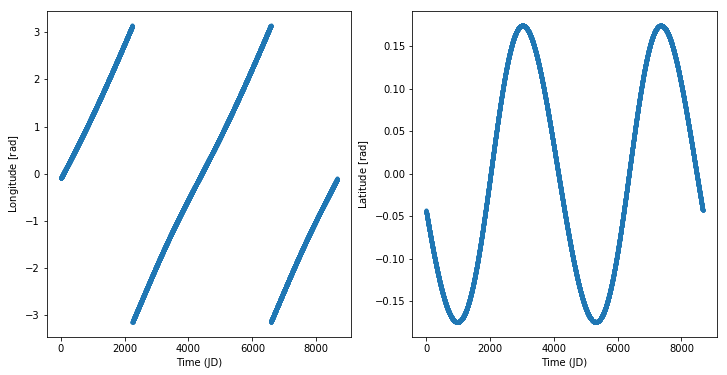

In [57]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,6)) 
ax1.plot(t.jd - t.jd[0], orb_ref.lon.wrap_at(180*u.deg).rad, marker='.', ls='') 
ax2.plot(t.jd - t.jd[0], orb_ref.lat.rad, marker='.', ls='')
ax1.set_ylabel(r'Longitude [{0:latex_inline}]'.format(u.rad))
ax2.set_ylabel(r'Latitude [{0:latex_inline}]'.format(u.rad))
for ax in (ax1,ax2):
    ax.set_xlabel('Time (JD)');

In [58]:
orb_plane = orb.orbital_plane(t)

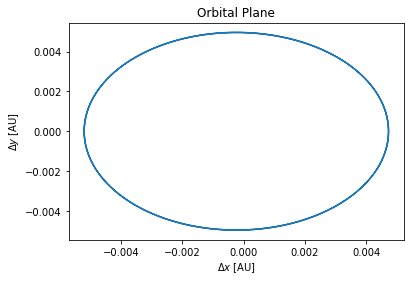

In [59]:
fig,ax = plt.subplots(1, 1) 
ax.plot(orb_plane.x,
        orb_plane.y, marker='') 
ax.set_xlabel(r'$\Delta x$ [{0:latex_inline}]'.format(u.au)) 
ax.set_ylabel(r'$\Delta y$ [{0:latex_inline}]'.format(u.au))
ax.set_title('Orbital Plane');

In [60]:
orb_icrs = orb.icrs(t)

In [61]:
offset_frame = coord.SkyOffsetFrame(origin=origin)
orb_offset = orb_icrs.transform_to(offset_frame)

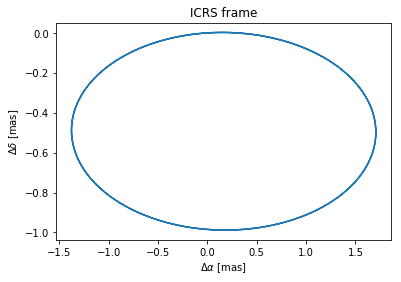

In [62]:
fig,ax = plt.subplots(1, 1) 
ax.plot(orb_icrs.ra.milliarcsecond - orb_icrs.ra.milliarcsecond[0],
        orb_icrs.dec.milliarcsecond - orb_icrs.dec.milliarcsecond[0], marker='') 
ax.set_xlabel(r'$\Delta\alpha$ [{0:latex_inline}]'.format(u.mas)) 
ax.set_ylabel(r'$\Delta\delta$ [{0:latex_inline}]'.format(u.mas))
ax.set_title('ICRS frame');

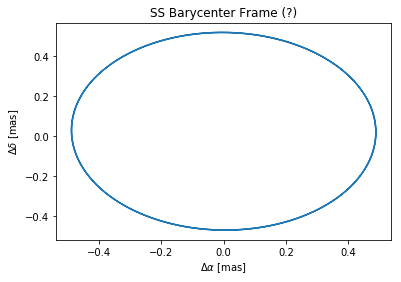

In [63]:
fig,ax = plt.subplots(1, 1) 
ax.plot(orb_offset.lon.wrap_at(180*u.deg).milliarcsecond,
        orb_offset.lat.milliarcsecond, marker='') 
ax.set_xlabel(r'$\Delta\alpha$ [{0:latex_inline}]'.format(u.mas)) 
ax.set_ylabel(r'$\Delta\delta$ [{0:latex_inline}]'.format(u.mas))
ax.set_title('SS Barycenter Frame (?)');